In [1]:
%matplotlib inline

In [2]:
import tqdm
import torch
import random
import math

from tqdm import tqdm
import numpy as np
from PIL import Image

import torch
from torch import nn, optim, Tensor
from torch.nn import functional as F
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms, utils

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from PIL import Image
import PIL.ImageFilter as ImageFilter

mpl.rcParams['figure.figsize'] = [10.0, 10.0]

In [3]:
class ImageListDataset(Dataset):
    def __init__(self, path, transform, resolution=8):
        # load the paths from the text file
        with open(path) as f:
            image_paths = []
            for line in f:
                line = line.strip()
                # good enough for now, make an issue if this fails.
                if line.lower().endswith(('gif', 'jpeg', 'jpg',  'png')):
                    image_paths.append(line)

        self.image_paths = image_paths
        self.transform = transform
        self.resolution = resolution

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        path = self.image_paths[index]
        img = Image.open(path).convert('RGB')
        img = self.transform(img)

        return img


In [22]:
BATCH_SIZE = 512
# BATCH_SIZE = 256
# BATCH_SIZE = 128
# BATCH_SIZE = 32
# BATCH_SIZE = 8
LEARNING_RATE = 0.0001
EPOCHS = 30
MOMENTUM = 0.9
# IN_POWER = 8
IN_POWER = 6


In [5]:
from autoencoder import ProGANAutoencoder

In [6]:
in_dim = 2 ** IN_POWER
in_dim

64

In [7]:
mean = (0.5, 0.5, 0.5)
stddev = (0.5, 0.5, 0.5)

net_transform = transforms.Compose([
    transforms.Resize(in_dim),
    transforms.RandomCrop(in_dim, pad_if_needed=True),
    transforms.ToTensor(),
    transforms.Normalize(mean, stddev)
])

In [8]:
def unnormalize(image, mean, std):
    image = ((image * std) + mean)
    return image

In [33]:
dataset = ImageListDataset("local_imagenet_items.txt", transform=net_transform)

In [10]:
def to_t_shape(data, shape):
    return Tensor(data).view(*shape)

tmean = to_t_shape(mean, (-1, 1, 1))
tstd = to_t_shape(stddev, (-1, 1, 1))

In [11]:
def view(tensor):
    tensor = tensor.detach().cpu()
    tensor = unnormalize(tensor, tmean, tstd).permute(1, 2, 0)
    tensor = tensor.numpy()
    return plt.imshow(tensor)

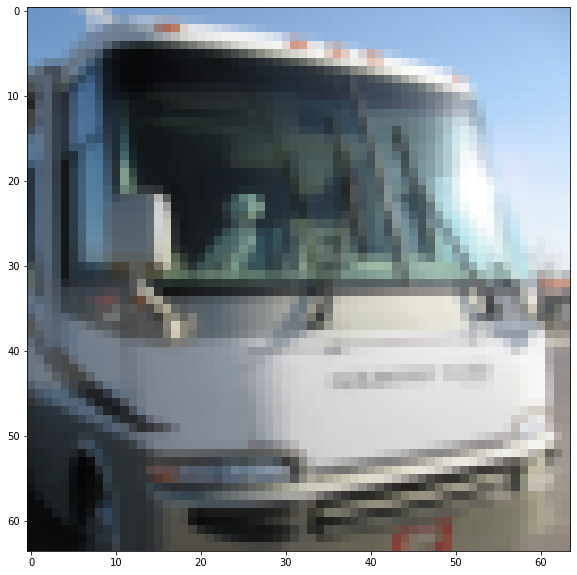

In [12]:
view(dataset[-1])

In [13]:
mean = (0.5, 0.5, 0.5)
stddev = (0.5, 0.5, 0.5)

net_transform = transforms.Compose([
    transforms.Resize(in_dim),
    transforms.RandomCrop(in_dim, pad_if_needed=True),
    transforms.ToTensor(),
    transforms.Normalize(mean, stddev)
])

In [34]:
trainloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=20
)

train_batches = math.ceil(len(dataset) / BATCH_SIZE)

In [15]:
model = ProGANAutoencoder(512, IN_POWER, 2)

In [16]:
model.cuda()
pass

In [17]:
# optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

In [18]:
def train_batch(inputs, model, optimizer):
    # get the inputs
    inputs = inputs.cuda()

    if torch.isnan(inputs).any():
        print("There's a NaN input!")
        return None

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, latents = model(inputs)
    
    if torch.isnan(outputs).any():
        print("There's a NaN output!")
        return None
    
    loss = model.loss(inputs, outputs, latents)
    loss.backward()
    optimizer.step()
    return loss

In [35]:
running_loss = 0
loss_steps = 5
epoch = 0

with tqdm(enumerate(trainloader, 0), total=train_batches, unit="batch") as t:
    for i, data in t:
        # get the inputs
        loss = train_batch(data, model, optimizer)
        

        if loss is None or torch.isnan(loss).any():
            print("There's a NaN loss!")
            break

        # print statistics
        running_loss += loss.item()
        if i % loss_steps == loss_steps - 1:  # print every N mini-batches
            string = '[%d, %5d] loss: %.8f' % (epoch + 1, i + 1, running_loss / loss_steps)
            t.set_postfix_str(string)
            running_loss = 0.0

100%|██████████| 2503/2503 [14:04<00:00,  2.96batch/s, [1,  2500] loss: 0.27620643]


In [23]:
image = dataset[-1]
image = image.cuda()

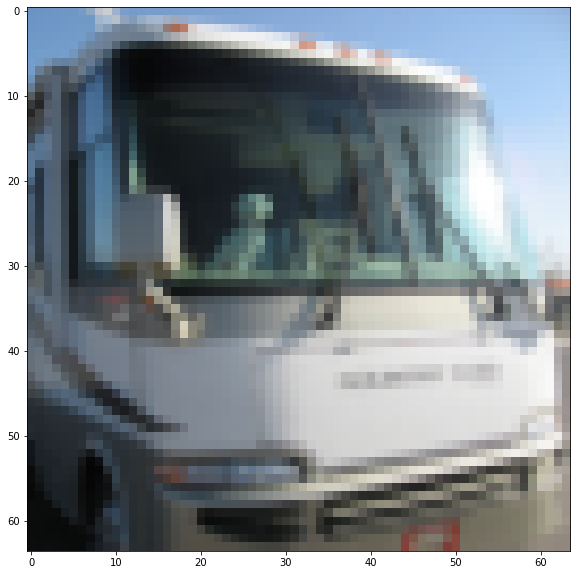

In [24]:
view(image)

In [29]:
def image_to_batch(image):
    return image.view(1, 3, in_dim, in_dim)

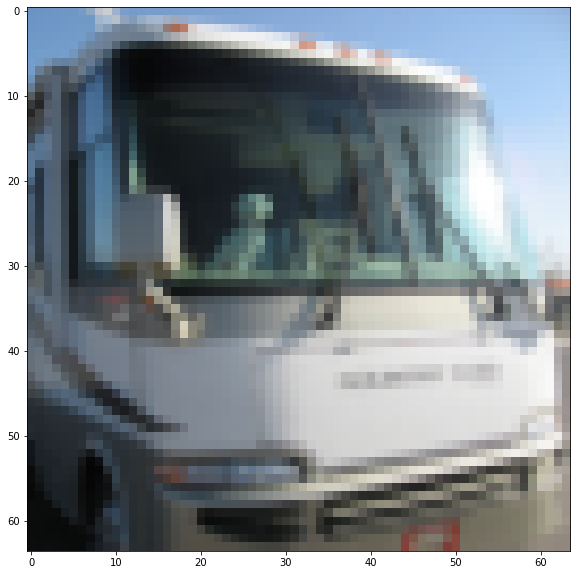

In [31]:
view(image_to_batch(image)[0])

In [36]:
output, latent = model(image.view(1, 3, in_dim, in_dim))

In [37]:
output.shape

torch.Size([1, 3, 64, 64])

In [38]:
output_just = output[0]
output_just.shape

torch.Size([3, 64, 64])

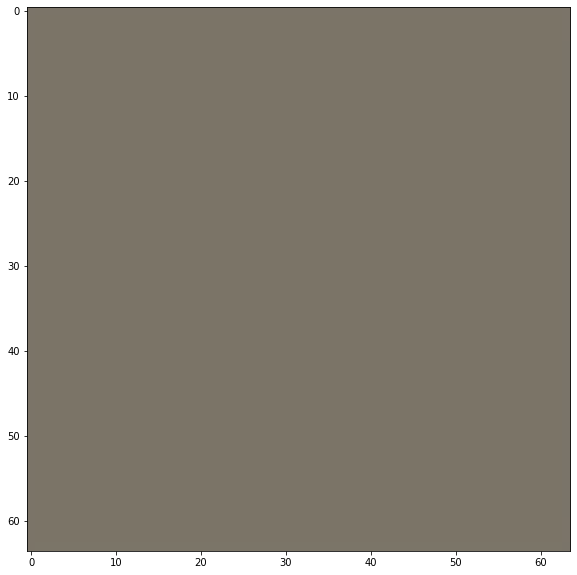

In [39]:
view(output_just)

In [ ]:
output_just